<a href="https://colab.research.google.com/github/shere-khan/machine_learning/blob/master/PyTorchAutoRegressiveModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

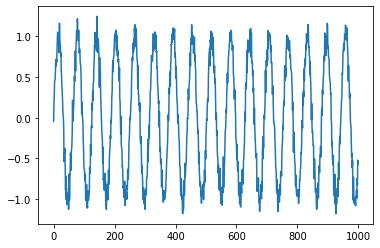

In [45]:
# make the synthetic data
N = 1000
series = np.sin(.1 * np.arange(N)) + np.random.randn(N) * .1

# plot it
plt.plot (series)
plt.show()

In [46]:
# build the dataset
# lets see if iwe can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f'X.shape {X.shape} Y.shape {Y.shape}')

X.shape (990, 10) Y.shape (990, 1)


In [47]:
# try autoregressive linear model
model = nn.Linear(T, 1)

In [48]:
# loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.1)

In [49]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [50]:
# training
def full_gd(model, criterion, optimizer, X_train, y_train,
            X_test, y_test, epochs=200):
  # stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses[it] = loss.item()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if(it + 1) % 5 == 0:
      print(f"""Epoch {it+1}/{epochs}, Train loss: {loss.item():.4f}, 
      Test loss: {test_loss.item()}""")

  return train_losses, test_losses

In [51]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train,
            X_test, y_test)

Epoch 5/200, Train loss: 0.0753, 
      Test loss: 0.09969035536050797
Epoch 10/200, Train loss: 0.0533, 
      Test loss: 0.05602056160569191
Epoch 15/200, Train loss: 0.0555, 
      Test loss: 0.04988826811313629
Epoch 20/200, Train loss: 0.0374, 
      Test loss: 0.028347602114081383
Epoch 25/200, Train loss: 0.0224, 
      Test loss: 0.017983466386795044
Epoch 30/200, Train loss: 0.0201, 
      Test loss: 0.018475359305739403
Epoch 35/200, Train loss: 0.0171, 
      Test loss: 0.017154185101389885
Epoch 40/200, Train loss: 0.0143, 
      Test loss: 0.016242070123553276
Epoch 45/200, Train loss: 0.0152, 
      Test loss: 0.01675286702811718
Epoch 50/200, Train loss: 0.0152, 
      Test loss: 0.01577223278582096
Epoch 55/200, Train loss: 0.0141, 
      Test loss: 0.014947757124900818
Epoch 60/200, Train loss: 0.0140, 
      Test loss: 0.015163750387728214
Epoch 65/200, Train loss: 0.0139, 
      Test loss: 0.014957784675061703
Epoch 70/200, Train loss: 0.0137, 
      Test loss: 0.014

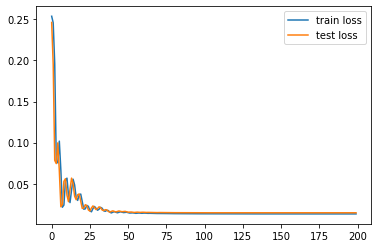

In [52]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [53]:
# "wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1, -1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

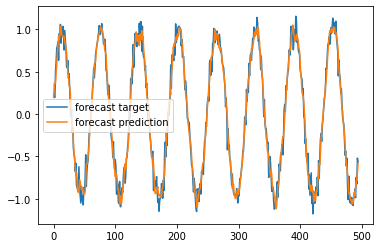

In [54]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [55]:
# forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1, -1)
  p = model(input_)

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))


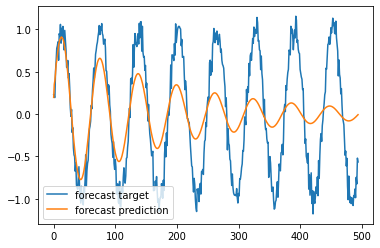

In [56]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()